In [43]:
from torchsummary import summary

In [122]:
device="cuda:0"

In [130]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*64*64, 16)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 256*64*64)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()

In [131]:
input_data = torch.randn(2,3,128,128)
summary(model,input_data)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 128, 128]       3,584
├─BatchNorm2d: 1-2                       [-1, 128, 128, 128]       256
├─Conv2d: 1-3                            [-1, 128, 128, 128]       147,584
├─BatchNorm2d: 1-4                       [-1, 128, 128, 128]       256
├─MaxPool2d: 1-5                         [-1, 128, 64, 64]         --
├─Conv2d: 1-6                            [-1, 256, 64, 64]         295,168
├─BatchNorm2d: 1-7                       [-1, 256, 64, 64]         512
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─BatchNorm2d: 1-9                       [-1, 256, 64, 64]         512
├─Linear: 1-10                           [-1, 16]                  16,777,232
Total params: 17,815,184
Trainable params: 17,815,184
Non-trainable params: 0
Total mult-adds (G): 6.11
Input size (MB): 0.38
Forward/backward pass size (MB): 96.00
Params size (MB): 67.96
Estima

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 128, 128]       3,584
├─BatchNorm2d: 1-2                       [-1, 128, 128, 128]       256
├─Conv2d: 1-3                            [-1, 128, 128, 128]       147,584
├─BatchNorm2d: 1-4                       [-1, 128, 128, 128]       256
├─MaxPool2d: 1-5                         [-1, 128, 64, 64]         --
├─Conv2d: 1-6                            [-1, 256, 64, 64]         295,168
├─BatchNorm2d: 1-7                       [-1, 256, 64, 64]         512
├─Conv2d: 1-8                            [-1, 256, 64, 64]         590,080
├─BatchNorm2d: 1-9                       [-1, 256, 64, 64]         512
├─Linear: 1-10                           [-1, 16]                  16,777,232
Total params: 17,815,184
Trainable params: 17,815,184
Non-trainable params: 0
Total mult-adds (G): 6.11
Input size (MB): 0.38
Forward/backward pass size (MB): 96.00
Params size (MB): 67.96
Estima

In [132]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [141]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    device="cuda:0"
    model.eval().to(device)
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels =  labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs,start_epoch=0):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img= img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels =  labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[int(labels[j])] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[int(predicted[j])] 
                              for j in range(batch_size)))

In [135]:
train_dataset

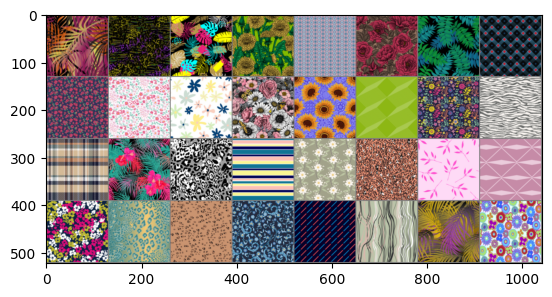

Real labels:  Botanical Leopard Botanical Big_Flowers Stripes Big_Flowers Botanical Chevron Ditsy Ditsy Micro Big_Flowers New folder Stripes Almsost_Ditsy Zebra Checks Botanical Leopard Stripes Abstract_Blossum Leopard Botanical Repeat Ditsy Leopard Leopard Riz_Leaves Stripes Stripes Botanical Micro
Predicted:  Stripes Stripes Stripes Micro Paisleys Stripes Big_Flowers Repeat Stripes Paisleys Paisleys Micro Repeat Repeat Repeat Chevron Stripes Stripes Stripes Stripes Repeat Repeat Stripes Micro Stripes Repeat Almsost_Ditsy Abstract_Blossum Stripes Stripes Repeat Stripes


In [136]:
testBatch()

In [114]:
classes={v-1:k for k,v in label_numeric.items()}

In [115]:
classes

{0: 'Abstract',
 1: 'Abstract_Blossum',
 2: 'Almsost_Ditsy',
 3: 'Big_Flowers',
 4: 'Botanical',
 5: 'Checks',
 6: 'Chevron',
 7: 'Ditsy',
 8: 'Leopard',
 9: 'Micro',
 10: 'Paisleys',
 11: 'Repeat',
 12: 'Riz_Leaves',
 13: 'Stripes',
 14: 'Zebra',
 15: 'New folder'}

In [103]:
batch_size=32
IMG_SIZE=128

In [104]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from torchvision import transforms
torch.manual_seed(0) 
class FabricDataset(Dataset):
    
    def __init__(self, data_folder, meta):
        super().__init__()
        self.df=pd.read_csv(meta, index_col=0)
        paths=self.df.path.tolist()
        labels=[label_numeric[l] for l in self.df.label.tolist()]
        
        self.data = [(f"{data_folder}/{path}", label-1) for path, label in zip(paths, labels)]

    def __getitem__(self, index):
        inst = self.data[index]
        return self.imge_to_tensor(inst[0]), inst[1]

    def __len__(self):
        return len(self.data)
    
    def imge_to_tensor(self, f):
        img = Image.open(f).convert('RGB')
        # trans_compose=transforms.ToTensor()
        transform = transforms.Compose([transforms.Resize([IMG_SIZE, IMG_SIZE]),
                                        # transforms.ColorJitter(hue=.05, saturation=.05),
                                        # transforms.RandomHorizontalFlip(),
                                        # transforms.RandomRotation(90, Image.BILINEAR),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])
      
        img_tensor=transform(img)
        return img_tensor

In [105]:
folders=[f for f in os.listdir("selection1") if "." not in f]
label_numeric={folder:i+1 for i,folder in enumerate(folders)}
dataset = FabricDataset("selection1","selection1_meta_data.csv")
len(dataset)

6219

In [128]:
len(train_dataset)

5597

In [129]:
len(test_dataset)

622

In [137]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [138]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
                                          drop_last=True)


In [143]:
train(400,200)

The model will be running on cuda:0 device
For epoch 201 the test accuracy over the whole test set is 24 %
For epoch 202 the test accuracy over the whole test set is 24 %
For epoch 203 the test accuracy over the whole test set is 24 %
For epoch 204 the test accuracy over the whole test set is 24 %
For epoch 205 the test accuracy over the whole test set is 24 %
For epoch 206 the test accuracy over the whole test set is 23 %
For epoch 207 the test accuracy over the whole test set is 25 %
For epoch 208 the test accuracy over the whole test set is 25 %
For epoch 209 the test accuracy over the whole test set is 24 %
For epoch 210 the test accuracy over the whole test set is 23 %
For epoch 211 the test accuracy over the whole test set is 25 %
For epoch 212 the test accuracy over the whole test set is 24 %
For epoch 213 the test accuracy over the whole test set is 25 %
For epoch 214 the test accuracy over the whole test set is 25 %
For epoch 215 the test accuracy over the whole test set is 24